![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Noelia's ML_OPS Project!  👻👻

###  Notebook: Recomendation System



![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Load all_ratings.csv 




![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [2]:
import pandas as pd
rating_all = pd.read_csv('../data/clean/filter/all_rating_filter_by_platform_by_movie.csv', index_col=0)
rating_all.head()

,userId,score,movieId
0,1,1.0,as680
1,1,4.5,ns2186
2,1,5.0,hs2381
3,1,5.0,ns3663
4,1,5.0,as9500


In [3]:
rating_all = rating_all[['userId', 'movieId','score']]
rating_all.head()


,userId,movieId,score
0,1,as680,1.0
1,1,ns2186,4.5
2,1,hs2381,5.0
3,1,ns3663,5.0
4,1,as9500,5.0


In [4]:
rating_all.groupby('userId')['score'].count().sort_values()

userId
111468     15
12316      15
31167      15
252230     15
66886      15
         ... 
17654     207
47359     207
261843    207
21083     207
37905     207
Name: score, Length: 76947, dtype: int64

In [5]:
rating_all.groupby('userId')['score'].count().sort_values().describe()

count    76947.000000
mean        55.903765
std         47.130904
min         15.000000
25%         19.000000
50%         37.000000
75%         78.000000
max        207.000000
Name: score, dtype: float64

<AxesSubplot: >

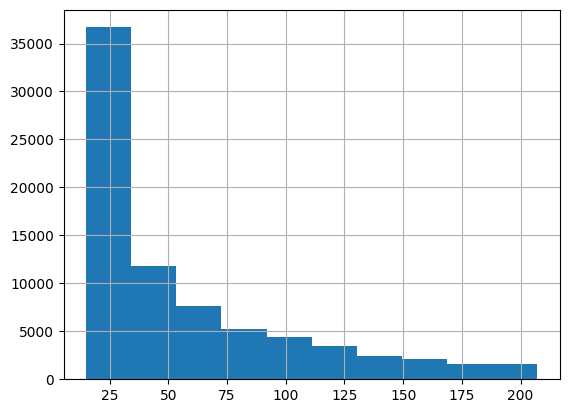

In [6]:
rating_all.groupby('userId')['score'].count().sort_values().hist()

---
### Select users with more than 20 reviews and less than 172 

---

In [7]:
cond1 = rating_all.groupby('userId')['score'].count().sort_values()>20
cond2 = rating_all.groupby('userId')['score'].count().sort_values()<1.5*(78-15)+78

selected_users = rating_all.groupby('userId')['score'].count()[cond1  & cond2].index.tolist()
# selected_users

In [8]:
partial_df = rating_all[rating_all['userId'].isin(selected_users)]
partial_df.shape

(3413430, 3)

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
### Distribution across score

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [9]:
vc = partial_df['score'].value_counts().sort_index()
vc

0.5     39639
1.0    100920
1.5     31323
2.0    186501
2.5     90732
3.0    693338
3.5    284191
4.0    974538
4.5    298172
5.0    714076
Name: score, dtype: int64

In [10]:
# Split in df for each review
df05 = partial_df.loc[partial_df['score']==0.5]
df10 = partial_df.loc[partial_df['score']==1]
df15 = partial_df.loc[partial_df['score']==1.5]
df20 = partial_df.loc[partial_df['score']==2]
df25 = partial_df.loc[partial_df['score']==2.5]
df30 = partial_df.loc[partial_df['score']==3]
df35 = partial_df.loc[partial_df['score']==3.5]
df40 = partial_df.loc[partial_df['score']==4]
df45 = partial_df.loc[partial_df['score']==4.5]
df50 = partial_df.loc[partial_df['score']==5]


In [11]:
# Create 10 dataframes of 100.000 or less of each class

dfs = []
for i in range(10):
    dff = pd.concat([df05.sample(100000,replace=True),df10.sample(100000,replace=True),df15.sample(100000,replace=True),df20.sample(100000,replace=True),
df25.sample(100000,replace=True),df30.sample(100000,replace=True),df35.sample(100000,replace=True),df40.sample(100000,replace=True),df45.sample(100000,replace=True),df50.sample(100000,replace=True)])
    dfs.append(dff)

In [265]:
dfs[0].shape

(1000000, 3)

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Load  dataset

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [266]:

from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

# Load Dataset rating data
readers = []

for i in range(10):
    reader = Reader(rating_scale=(0.5, 5))
    readers.append(reader)

dps = []
for i in range(10):
    dps.append(Dataset.load_from_df(dfs[i][['userId', 'movieId', 'score']], readers[i]))


![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
### Split in train / test

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [268]:
# Split in train, test

train_test_sets = []
for dp in dps:
    train1, test1 = train_test_split(dp, test_size = 0.15)
    train_test_sets.append((train1,test1))


In [269]:
len(train_test_sets)

10

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
### Create the model

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [270]:
models = []

for i in range(10):
    m1 = SVD(n_factors=10, n_epochs=10, lr_all=0.005, reg_all=0.1)
    models.append(m1)


![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
### Train the models on train datasets

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [271]:
for idx, m1 in enumerate(models):
    m1.fit(train_test_sets[i][0])

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
### Predict for 1 user, 1 movie

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [272]:
option1 = {
    'userId':66575,
    'movieId':'ns5785',
    'score':1.5
}

option2= {
    'userId':258545,
    'movieId':'as922',
    'score':0.5
}

option3= {
    'userId':118361,
    'movieId':'as8025',
    'score':3.5
}

option4= {
    'userId':7793,
    'movieId':'ns7444',
    'score':5.0
}

options = [option1,option2,option3,option4]

In [284]:
j=2
userId=options[j]['userId']
movieId =options[j]['movieId']
preds = []
for i in range(10):
    p1 = models[i].predict(userId, movieId).est
    preds.append(p1)

for pred in preds:
    print("prediction --> ", pred)

print("True score --> ", options[j]['score'])


prediction -->  2.567866371058548
prediction -->  2.5560536197184525
prediction -->  2.516801471925606
prediction -->  2.5268008236169677
prediction -->  2.5279901935768123
prediction -->  2.614921238974507
prediction -->  2.62917631211705
prediction -->  2.5323932141068877
prediction -->  2.5461276239830295
prediction -->  2.6087803770203557
True score -->  3.5


![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
### Predict using an ensemble
![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)



In [280]:
import numpy as np
def make_ensemble_predictions(userId, movieId):
    preds = []
    for i in range(10):
        p1 = models[i].predict(userId, movieId).est
        preds.append(p1)
    
   
    preds = np.array(preds)
    votes = preds>2.5
    nvotes = np.count_nonzero(votes)
    if nvotes>4:
        return "Recomended Movie"
    else:
        return "not recommended Movie"

In [285]:
make_ensemble_predictions(userId, movieId)

'Recomended Movie'

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
### rmse across all test set
![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [286]:
from surprise import accuracy
# Calcular las predicciones sobre los datos de prueba

all_preds = []
for idx, model in enumerate(models):
    all_preds.append(model.test(train_test_sets[i][1]))

all_rmse = []
for p in all_preds:
    all_rmse.append(accuracy.rmse(p))

RMSE: 1.2439
RMSE: 1.2438
RMSE: 1.2439
RMSE: 1.2439
RMSE: 1.2438
RMSE: 1.2439
RMSE: 1.2438
RMSE: 1.2440
RMSE: 1.2438
RMSE: 1.2439


![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
### Save the model

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [287]:
import pickle
import os

# Individual

root_path = '../data/models/ensamble1/'
isExist = os.path.exists(root_path)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(root_path)

for idx, m in enumerate(models):
    with open(root_path+'m'+str(idx)+'.pkl', 'wb') as f:
        pickle.dump(m, f)

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
### If we need to load the model
![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [ ]:
import pickle

# Cargar el modelo desde el archivo
with open('model_platform.pkl', 'rb') as f:
    model_platform = pickle.load(f)

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
### Save dataframe with movie title

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [18]:
dfmovie = pd.read_csv('../data/clean/all_together_with_score.csv', index_col=0)
dfmovie_mini = dfmovie[['id','title']]
dfmovie_mini = dfmovie_mini.groupby('id').first()
dfmovie_mini


,title
id,
as1,the grand seduction
as10,david's mother
as100,wilder napalm
as1000,sinbad: make me wanna holla
as1001,simple gifts: the chamber music society at sha...
...,...
ns995,this lady called life
ns996,vizontele
ns997,homunculus


In [22]:
# Load ratings data
df_save = partial_df

# promote id as index
df_save.set_index('movieId', inplace=True)

# Assign a new column name
df_save = df_save.assign(title = dfmovie_mini)

# Reset index
df_save.reset_index(inplace=True)
df_save.head()

,movieId,userId,score,title
0,as680,1,1.0,the english civil war
1,ns2186,1,4.5,latte and the magic waterstone
2,hs2381,1,5.0,la diosa coronada
3,ns3663,1,5.0,"frankenstein’s monster’s monster, frankenstein"
4,as9500,1,5.0,kept woman


In [23]:
# save complete dataframe to a file all_ratings_with_title.csv
df_save.to_csv('../data/clean/all_ratings_with_title.csv')

![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
### Cross validation
![divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [ ]:
# model_cv = SVD(n_factors=50)
# x = cross_validate(model_cv, data_platform, measures=['RMSE', 'MAE'], cv=2, verbose=True)